# PDAC Calibration - 1y probability changes

Author: Sophie Wagner, sw3767@cumc.columbia.edu

## Packages, notebook preferences, etc.

In [1]:
# Required Packages
import numpy as np  # For matrix manipulation
import pandas as pd  # For output/input data processing
import matplotlib.pyplot as plt  # For visualizations
from csaps import csaps
from tqdm import tqdm
from datetime import datetime
import random 

# Add the src directory to the Python path
import sys
import os
sys.path.append(os.path.abspath('../src'))

# Load .py files
import common_functions as func
import calibration_plots as p
import configs as c
import gof

# Some aesthetic options
np.set_printoptions(suppress=True, linewidth=300, formatter={'float': '{: 0.9f}'.format})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Set up matrix

In [71]:
def row_normalize(matrix):
    for age_layer in range(matrix.shape[0]):  # Loop over each age layer
        layer = matrix[age_layer]
        for row_idx in range(layer.shape[0]):  # Loop over each row
            row = layer[row_idx]
            non_diag_sum = np.sum(row) - row[row_idx] 
            
            if non_diag_sum > 1:  # If the non-diag probabilities exceed 1
                scaling_factor = 1 / non_diag_sum
                row *= scaling_factor  # Scale 
            
            row[row_idx] = max(0, 1 - non_diag_sum)
    
    return matrix.clip(0.0,1.0)

def create_matrix():
    
    matrix = np.zeros((len(c.age_layers), len(c.health_states_itos), len(c.health_states_itos)))
    age_50_idx = 6 if c.param_interval == 5 else 30
    matrix[:, 0, 1] = 1-(1-0.0011)**(1/25) # average risk after 50 ~ 0.0011, transformed to annual prob
    matrix[:age_50_idx, 0, 1] = np.linspace(0.000001,matrix[-1,0,1],age_50_idx)
    matrix[:, 1, 2] = 0.380016 # c.model_inputs_dict['p_Local_to_Regional_PC']  
    matrix[:, 2, 3] = 0.666632 # c.model_inputs_dict['p_Regional_to_Distant_PC']
    matrix[:, 1, 4] = 0.040325 # c.model_inputs_dict['p_symptom_local'] 
    matrix[:, 2, 5] = 0.328861 # c.model_inputs_dict['p_symptom_regional']
    matrix[:, 3, 6] = 0.332143 # c.model_inputs_dict['p_symptom_distant']
    
    matrix = add_acm(matrix)  # ACM
    matrix = add_csd(matrix)  # CSD
    matrix = constrain_matrix(matrix)  # constrain
    matrix = row_normalize(matrix)  # normalize

    return matrix


def constrain_matrix(matrix):
    
    matrix[:, 0, 1] = np.maximum(matrix[:,0,1], 0.0000001)
    matrix[:, 0, 1] = np.maximum.accumulate(matrix[:, 0, 1])
    matrix[:, 1, 2] = np.maximum(matrix[:, 0, 1], matrix[:, 1, 2])
    matrix[:, 2, 3] = np.maximum(matrix[:, 1, 2], matrix[:, 2, 3])
    matrix[:, 2, 5] = np.maximum(matrix[:, 1, 4], matrix[:, 2, 5])
    matrix[:, 3, 6] = np.maximum(matrix[:, 2, 5], matrix[:, 3, 6])
    
    return matrix


def add_acm(matrix):
    
    # Note: c.acm_rates configured for either 1y or 5y acm
    matrix[:, :7, 8] = c.acm_rates[:, np.newaxis]
    matrix[:, 8, 8] = 1
    
    return matrix


def add_csd(matrix):  # Constant death rate in calibration
    
    matrix[:, 4, 7] = c.model_inputs_dict['p_local_death']
    matrix[:, 5, 7] = c.model_inputs_dict['p_regional_death']
    matrix[:, 6, 7] = c.model_inputs_dict['p_distant_death']
    matrix[:, 7, 7] = 1
    
    return matrix

## Markov model

In [94]:
def run_markov(matrix, starting_age=20, max_age=84):
    
    current_age = starting_age
    age_layer = 0
    month_pop, pop_log = c.starting_pop, c.starting_pop  # (13, 1)
    inc_log = np.zeros(pop_log.shape)  # to track new incidences in each state
    matrixT = matrix.transpose(0,2,1)  # (13, 9, 9)
    inflow_matrix = np.tril(matrixT, k=-1)
    
    while current_age < max_age:            

        # Matrix multiplication (state transition)
        mat, inflow_mat = matrixT[age_layer], inflow_matrix[age_layer] 
        month_inc = np.matmul(inflow_mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
        month_pop = np.matmul(mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
         
        # Add to log
        inc_log = np.concatenate((inc_log, month_inc), axis=1)  # (13, 65)
        pop_log = np.concatenate((pop_log, month_pop), axis=1)  # (13, 65)
        
        current_age += 1
        if current_age in c.ages_1y:
            age_layer += 1
            
    incidence, incidence_unadj = inc_log.copy(), inc_log.copy()
    dead_factor = np.divide(c.N, c.N - pop_log[7:, :].sum(axis=0))  # inc and prev denominator is out of living only
    prevalence = np.zeros(pop_log.shape) 

    for state in range(9):
        incidence[state, :] = np.multiply(incidence[state, :], dead_factor)
        prevalence[state, :] = np.multiply(pop_log[state, :], dead_factor)

    return incidence, prevalence, incidence_unadj, pop_log

## Calibration

In [95]:
def step(matrix, step_size, num_adj=3):
    """
    Updates a parameter matrix, using reduced 5-y interval matrix (to reduce number of
    parameters to adjust, faster convergence, smoother parameter change). Randomly 
    selected transitions and age groups are adjusted by a scaled step size, then smoothed
    and interpolated to get yearly values.

    Args:
        matrix (numpy.ndarray): Full parameter matrix for all ages and transitions.
        step_size (float): Scale of parameter adjustments.
        num_adj (int): Number of parameters to modify.

    Returns:
        numpy.ndarray: Updated matrix with smoothed yearly transition probabilities.
    """
    points = list(c.transitions_itos.keys()) 
    step_tp = random.choices(points, k=num_adj)
    step_age = random.choices(c.age_layers_5y, k=num_adj)
    small_matrix = matrix[2::5, :, :]
    assert small_matrix.shape[0] == 13
    
    for i in range(num_adj):
        (from_state, to_state), age = step_tp[i], step_age[i]
        old_param = small_matrix[age, from_state, to_state] 
        step_param = old_param * step_size
        small_matrix[age, from_state, to_state] += np.random.uniform(low=-step_param, high=step_param)

    small_matrix[-1, :, :] = np.minimum(small_matrix[-1, :, :], small_matrix[-2, :, :])  # Limit exponential increase
    new_matrix = csaps([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5], small_matrix, axis=0, smooth=0.001)(c.ages_1y).clip(0.0,1.0)
    assert new_matrix.shape[0]==65

    return new_matrix

In [ ]:
def progress_report(iteration, best_eval, best_log, ticker, best_t):
    """
    Prints progress report during simulated annealing.
    """
    log_adj, _, inc_log, _ = best_log
    total_dxd = np.sum(inc_log[4:7, :]) / c.N
    print(f"{iteration}: Best Eval: {best_eval:.5f}, PDAC: {total_dxd:.5f}, Tick: {ticker}")
    
    if iteration % 50000 == 0:
        transition_probs = p.extract_transition_probs(best_t, metric="avg")
        print(f"Detailed Progress Report, Iteration = {iteration}")
        print(transition_probs)
        p.plot_vs_seer(log_adj, c.seer_inc)

In [96]:
def simulated_annealing(n_iterations, step_size, start_tmat, n_adj=5, starting_temp=1, verbose=False, print_interval=1000):
    """
    Performs simulated annealing to optimize a transition matrix.

    Args:
        n_iterations (int): Number of iterations for optimization.
        step_size (float): Step size for parameter adjustments.
        start_tmat (numpy.ndarray): Initial transition matrix.
        n_adj (int): Number of parameters to adjust per step.
        starting_temp (float): Initial temperature for annealing.
        verbose (bool): Whether to print progress reports.
        print_interval (int): Interval for progress reporting.

    Returns:
        numpy.ndarray: Optimized transition matrix.
    """
    best_t = np.copy(start_tmat)
    best_log = run_markov(best_t)
    best_eval = gof.objective(best_log)
    curr_t, curr_eval = best_t, best_eval
    ticker = 0

    with tqdm(total=n_iterations, desc="Simulated annealing progress", unit="iteration") as pbar:
        for i in range(n_iterations):
            # Generate candidate solution
            candidate_t = step(np.copy(curr_t), step_size, n_adj)
            candidate_log = run_markov(candidate_t)
            candidate_eval = gof.objective(candidate_log)

            # Update best solution
            if candidate_eval < best_eval:
                ticker = 0
                best_t, best_eval = np.copy(candidate_t), candidate_eval
                best_log = run_markov(best_t)
            else:
                ticker += 1

            # Calculate temperature and Metropolis acceptance criterion
            t = starting_temp / (1 + 0.1 * np.log(i + 1))
            diff = candidate_eval - curr_eval
            metropolis = np.exp(-diff / t)

            if diff < 0 or np.random.random() < metropolis:
                curr_t, curr_eval = np.copy(candidate_t), candidate_eval
                ticker = 0

            # Print progress report
            if verbose and i > 0 and i % print_interval == 0:
                progress_report(i, best_eval, best_log, ticker, best_t)

            pbar.update(1)

    print("Best evaluation:", best_eval)
    return best_t

## Run simulated annealing

In [97]:
def run_sa(tmat=None, save_all=False, n_iterations=50000, step_size=0.2, n_adj=5, starting_temp=1, print_interval=5000):
    
    start_tmat = None
    start_tmat = tmat if tmat is not None else create_matrix()   
    initial_score = gof.objective(run_markov(start_tmat))
    print(f"Initial score: {round(initial_score, 5)}")
    print("Starting calibration...")
    
    result = simulated_annealing(n_iterations=n_iterations, step_size=step_size, start_tmat=start_tmat, n_adj=n_adj, starting_temp=starting_temp, verbose=True, print_interval=print_interval)
    
    # Gather results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    curr_tmat = result.copy()
    curr_log = run_markov(curr_tmat)
    log_adj, log_prev, log_inc, pop_log = curr_log
    tps = p.extract_transition_probs(curr_tmat, "markov", metric="avg", save=save_all, timestamp=timestamp)
    
    print("Done.")
    
    # Saving
    if save_all:
        log_path, tmat_path, plot_path = c.OUTPUT_PATHS["logs"], c.OUTPUT_PATHS["tmats"], c.OUTPUT_PATHS["plots"]
        np.save(f"{tmat_path}/{timestamp}_tmat.npy", curr_tmat)
        pd.DataFrame(log_adj).to_csv(f"{log_path}/{timestamp}_inc_adj.csv")
        pd.DataFrame(log_prev).to_csv(f"{log_path}/{timestamp}_prev.csv")
        pd.DataFrame(log_inc).to_csv(f"{log_path}/{timestamp}_inc_unadj.csv")
        pd.DataFrame(pop_log.T).to_csv(f"{log_path}/{timestamp}_pop_log.csv")
        p.plot_vs_seer(log_adj, c.seer_inc, save_imgs=True, show_plot=False, outpath=plot_path, timestamp=timestamp)
        p.plot_vs_seer_total(log_adj, c.seer_inc, save_imgs=True, show_plot=False, outpath=plot_path, timestamp=timestamp)
        
    else:
        print("\nOUTPUTS:")
        print(tps)
        p.plot_vs_seer(log_adj, c.seer_inc, show_plot=True)
        p.plot_vs_seer_total(log_adj, c.seer_inc, show_plot=True)
        p.plot_params(curr_tmat,  show_plot=True)

    return curr_tmat

In [98]:
result=None
temps, step_sizes = [2,2,1,1,1], [0.25,0.2,0.2,0.15,0.1]
for epoch in range(5):
    print(f"EPOCH {(epoch+1)}/5 ----------------------------------------------------------")
    result = run_sa(tmat=result, save_all=True, n_iterations=200000, step_size=step_sizes[epoch], n_adj=7, starting_temp=temps[epoch])

EPOCH 1/5 ----------------------------------------------------------
[[ 0.999251000  0.000001000  0.000000000  0.000000000  0.000000000  0.000000000  0.000000000  0.000000000  0.000748000]
 [ 0.000000000  0.578911000  0.380016000  0.000000000  0.040325000  0.000000000  0.000000000  0.000000000  0.000748000]
 [ 0.000000000  0.000000000  0.003759000  0.666632000  0.000000000  0.328861000  0.000000000  0.000000000  0.000748000]
 [ 0.000000000  0.000000000  0.000000000  0.667109000  0.000000000  0.000000000  0.332143000  0.000000000  0.000748000]
 [ 0.000000000  0.000000000  0.000000000  0.000000000  0.789252000  0.000000000  0.000000000  0.210000000  0.000748000]
 [ 0.000000000  0.000000000  0.000000000  0.000000000  0.000000000  0.659252000  0.000000000  0.340000000  0.000748000]
 [ 0.000000000  0.000000000  0.000000000  0.000000000  0.000000000  0.000000000  0.499252000  0.500000000  0.000748000]
 [ 0.000000000  0.000000000  0.000000000  0.000000000  0.000000000  0.000000000  0.00000000

Simulated annealing progress:   3%|▎         | 5064/200000 [00:15<08:49, 368.20iteration/s]

5000 :  1076.2539095713905    PDAC:  0.00314    tick: 220


Simulated annealing progress:   5%|▌         | 10050/200000 [00:32<09:49, 322.27iteration/s]

10000 :  955.3785825665819    PDAC:  0.00346    tick: 171


Simulated annealing progress:   8%|▊         | 15051/200000 [00:48<08:12, 375.41iteration/s]

15000 :  880.2987691195619    PDAC:  0.00375    tick: 71


Simulated annealing progress:  10%|█         | 20080/200000 [01:02<07:54, 378.93iteration/s]

20000 :  764.9671815109425    PDAC:  0.00418    tick: 1055


Simulated annealing progress:  13%|█▎        | 25050/200000 [01:16<08:10, 356.33iteration/s]

25000 :  693.3323628787629    PDAC:  0.00446    tick: 1231


Simulated annealing progress:  15%|█▌        | 30055/200000 [01:29<07:23, 383.38iteration/s]

30000 :  611.9115345808498    PDAC:  0.00501    tick: 2272


Simulated annealing progress:  18%|█▊        | 35047/200000 [01:42<07:34, 362.57iteration/s]

35000 :  575.5855799346748    PDAC:  0.0052    tick: 1101


Simulated annealing progress:  20%|██        | 40053/200000 [01:56<08:25, 316.65iteration/s]

40000 :  525.7890230220615    PDAC:  0.00549    tick: 133


Simulated annealing progress:  23%|██▎       | 45063/200000 [02:09<06:55, 372.90iteration/s]

45000 :  484.9265059063738    PDAC:  0.00565    tick: 317


Simulated annealing progress:  25%|██▌       | 50039/200000 [02:22<06:42, 372.26iteration/s]

50000 :  327.0403413506829    PDAC:  0.00643    tick: 1992
Progress report, i = 50000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00001  0.00007  0.00000  0.00008  0.00004
1  u_PDAC_loc  u_PDAC_reg  0.14288  1.00000  0.00000  1.00000  0.57945
2  u_PDAC_reg  u_PDAC_dis  0.39188  0.93682  0.22326  0.99289  0.67846
3  u_PDAC_loc  d_PDAC_loc  0.01996  0.02423  0.01799  0.02587  0.02228
4  u_PDAC_reg  d_PDAC_reg  0.19227  0.31139  0.17919  0.34149  0.24481
5  u_PDAC_dis  d_PDAC_dis  0.06489  0.47101  0.00000  0.51472  0.27524


Simulated annealing progress:  28%|██▊       | 55040/200000 [02:41<06:29, 372.32iteration/s]

55000 :  261.174636095745    PDAC:  0.00691    tick: 724


Simulated annealing progress:  30%|███       | 60054/200000 [02:57<06:06, 382.24iteration/s]

60000 :  228.37507769717757    PDAC:  0.00703    tick: 473


Simulated annealing progress:  33%|███▎      | 65043/200000 [03:10<06:10, 364.48iteration/s]

65000 :  169.9574947339525    PDAC:  0.00732    tick: 425


Simulated annealing progress:  35%|███▌      | 70064/200000 [03:23<05:40, 381.41iteration/s]

70000 :  149.04999685991504    PDAC:  0.00741    tick: 783


Simulated annealing progress:  38%|███▊      | 75062/200000 [03:37<05:25, 384.04iteration/s]

75000 :  123.4713314551845    PDAC:  0.0079    tick: 285


Simulated annealing progress:  40%|████      | 80051/200000 [03:51<05:13, 382.54iteration/s]

80000 :  100.96539458937568    PDAC:  0.00813    tick: 4853


Simulated annealing progress:  43%|████▎     | 85070/200000 [04:04<04:54, 390.33iteration/s]

85000 :  100.96539458937568    PDAC:  0.00813    tick: 86


Simulated annealing progress:  45%|████▌     | 90051/200000 [04:17<04:40, 391.53iteration/s]

90000 :  95.00486899640772    PDAC:  0.00843    tick: 3421


Simulated annealing progress:  48%|████▊     | 95060/200000 [04:31<05:04, 344.48iteration/s]

95000 :  92.93400384220209    PDAC:  0.00828    tick: 500


Simulated annealing progress:  50%|█████     | 100074/200000 [04:46<04:33, 365.55iteration/s]

100000 :  85.16657808173967    PDAC:  0.00842    tick: 761
Progress report, i = 100000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00003  0.00016  0.00000  0.00017  0.00010
1  u_PDAC_loc  u_PDAC_reg  0.15476  1.00000  0.00000  1.00000  0.60483
2  u_PDAC_reg  u_PDAC_dis  0.11044  0.77060  0.00000  0.80086  0.46259
3  u_PDAC_loc  d_PDAC_loc  0.01753  0.01718  0.01679  0.01815  0.01718
4  u_PDAC_reg  d_PDAC_reg  0.04838  0.27267  0.00000  0.30558  0.16104
5  u_PDAC_dis  d_PDAC_dis  0.02803  0.23090  0.00000  0.25213  0.13221


Simulated annealing progress:  53%|█████▎    | 105059/200000 [04:59<04:12, 375.65iteration/s]

105000 :  79.00820629639908    PDAC:  0.00843    tick: 592


Simulated annealing progress:  55%|█████▌    | 110082/200000 [05:12<03:47, 394.84iteration/s]

110000 :  79.00820629639908    PDAC:  0.00843    tick: 5592


Simulated annealing progress:  58%|█████▊    | 115042/200000 [05:26<03:51, 367.38iteration/s]

115000 :  79.00820629639908    PDAC:  0.00843    tick: 10592


Simulated annealing progress:  60%|██████    | 120050/200000 [05:39<03:35, 370.25iteration/s]

120000 :  77.39469883194766    PDAC:  0.00859    tick: 2781


Simulated annealing progress:  63%|██████▎   | 125036/200000 [05:53<03:10, 393.61iteration/s]

125000 :  76.20138197159841    PDAC:  0.00845    tick: 1845


Simulated annealing progress:  65%|██████▌   | 130049/200000 [06:06<03:00, 388.58iteration/s]

130000 :  67.8003372697255    PDAC:  0.00878    tick: 3315


Simulated annealing progress:  68%|██████▊   | 135004/200000 [06:19<03:05, 349.55iteration/s]

135000 :  67.69440850635006    PDAC:  0.00868    tick: 3414


Simulated annealing progress:  70%|███████   | 140059/200000 [06:33<02:35, 386.28iteration/s]

140000 :  67.69440850635006    PDAC:  0.00868    tick: 4848


Simulated annealing progress:  73%|███████▎  | 145061/200000 [06:46<02:20, 391.50iteration/s]

145000 :  67.69440850635006    PDAC:  0.00868    tick: 9848


Simulated annealing progress:  75%|███████▍  | 149983/200000 [06:59<02:11, 379.00iteration/s]

150000 :  62.53587482072099    PDAC:  0.00901    tick: 305
Progress report, i = 150000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00003  0.00023  0.00000  0.00026  0.00013
1  u_PDAC_loc  u_PDAC_reg  0.17296  0.99610  0.00000  1.00000  0.62544
2  u_PDAC_reg  u_PDAC_dis  0.10636  0.65331  0.00000  0.66707  0.41023
3  u_PDAC_loc  d_PDAC_loc  0.01807  0.01687  0.01684  0.01877  0.01732
4  u_PDAC_reg  d_PDAC_reg  0.02809  0.20449  0.00000  0.22758  0.11829
5  u_PDAC_dis  d_PDAC_dis  0.03420  0.19692  0.00000  0.20575  0.12218


Simulated annealing progress:  78%|███████▊  | 155065/200000 [07:12<01:53, 396.93iteration/s]

155000 :  62.53587482072099    PDAC:  0.00901    tick: 570


Simulated annealing progress:  80%|████████  | 160070/200000 [07:26<01:44, 380.57iteration/s]

160000 :  62.53587482072099    PDAC:  0.00901    tick: 665


Simulated annealing progress:  83%|████████▎ | 165048/200000 [07:42<01:33, 372.95iteration/s]

165000 :  62.53587482072099    PDAC:  0.00901    tick: 3590


Simulated annealing progress:  85%|████████▌ | 170035/200000 [07:56<01:17, 388.86iteration/s]

170000 :  62.53587482072099    PDAC:  0.00901    tick: 4614


Simulated annealing progress:  88%|████████▊ | 175056/200000 [08:09<01:05, 382.54iteration/s]

175000 :  62.53587482072099    PDAC:  0.00901    tick: 9614


Simulated annealing progress:  90%|█████████ | 180067/200000 [08:22<00:52, 381.58iteration/s]

180000 :  62.53587482072099    PDAC:  0.00901    tick: 130


Simulated annealing progress:  93%|█████████▎| 185039/200000 [08:37<00:37, 394.99iteration/s]

185000 :  62.53587482072099    PDAC:  0.00901    tick: 5130


Simulated annealing progress:  95%|█████████▌| 190068/200000 [08:50<00:26, 381.94iteration/s]

190000 :  62.53587482072099    PDAC:  0.00901    tick: 2147


Simulated annealing progress:  98%|█████████▊| 195059/200000 [09:03<00:12, 386.21iteration/s]

195000 :  62.53587482072099    PDAC:  0.00901    tick: 1818


Simulated annealing progress: 100%|██████████| 200000/200000 [09:16<00:00, 359.28iteration/s]


62.53587482072099
Done.

OUTPUTS:
EPOCH 2/5 ----------------------------------------------------------
Initial score: 62.53587
Starting calibration...


Simulated annealing progress:   3%|▎         | 5041/200000 [00:13<09:23, 345.74iteration/s]

5000 :  62.53587482072099    PDAC:  0.00901    tick: 4843


Simulated annealing progress:   5%|▌         | 10066/200000 [00:27<08:33, 369.65iteration/s]

10000 :  62.447297590116364    PDAC:  0.00874    tick: 4768


Simulated annealing progress:   8%|▊         | 15053/200000 [00:41<08:08, 378.90iteration/s]

15000 :  62.447297590116364    PDAC:  0.00874    tick: 9768


Simulated annealing progress:  10%|█         | 20047/200000 [00:54<07:57, 377.06iteration/s]

20000 :  62.447297590116364    PDAC:  0.00874    tick: 1024


Simulated annealing progress:  13%|█▎        | 25073/200000 [01:07<07:36, 383.22iteration/s]

25000 :  62.447297590116364    PDAC:  0.00874    tick: 6024


Simulated annealing progress:  15%|█▌        | 30081/200000 [01:20<07:26, 380.80iteration/s]

30000 :  62.447297590116364    PDAC:  0.00874    tick: 1139


Simulated annealing progress:  18%|█▊        | 35045/200000 [01:34<07:13, 380.75iteration/s]

35000 :  62.447297590116364    PDAC:  0.00874    tick: 597


Simulated annealing progress:  20%|██        | 40072/200000 [01:47<07:10, 371.90iteration/s]

40000 :  62.447297590116364    PDAC:  0.00874    tick: 1175


Simulated annealing progress:  23%|██▎       | 45081/200000 [02:00<06:45, 382.41iteration/s]

45000 :  62.447297590116364    PDAC:  0.00874    tick: 2615


Simulated annealing progress:  25%|██▌       | 50042/200000 [02:14<06:44, 371.01iteration/s]

50000 :  62.447297590116364    PDAC:  0.00874    tick: 3320
Progress report, i = 50000
   From State    To State   Age 30   Age 75     Min      Max      Avg
0     healthy  u_PDAC_loc  0.00003  0.00021  0.0000  0.00022  0.00013
1  u_PDAC_loc  u_PDAC_reg  0.18069  1.00000  0.0000  1.00000  0.63548
2  u_PDAC_reg  u_PDAC_dis  0.11028  0.65684  0.0000  0.69178  0.40478
3  u_PDAC_loc  d_PDAC_loc  0.01810  0.01681  0.0168  0.01868  0.01735
4  u_PDAC_reg  d_PDAC_reg  0.02709  0.21514  0.0000  0.24661  0.11891
5  u_PDAC_dis  d_PDAC_dis  0.03377  0.19301  0.0000  0.20694  0.11822


Simulated annealing progress:  28%|██▊       | 55081/200000 [02:27<06:24, 377.00iteration/s]

55000 :  62.447297590116364    PDAC:  0.00874    tick: 8320


Simulated annealing progress:  30%|███       | 60052/200000 [02:41<06:08, 379.67iteration/s]

60000 :  62.447297590116364    PDAC:  0.00874    tick: 1313


Simulated annealing progress:  33%|███▎      | 65071/200000 [02:55<05:57, 376.92iteration/s]

65000 :  62.447297590116364    PDAC:  0.00874    tick: 6313


Simulated annealing progress:  35%|███▌      | 70069/200000 [03:08<05:35, 387.75iteration/s]

70000 :  62.447297590116364    PDAC:  0.00874    tick: 11313


Simulated annealing progress:  38%|███▊      | 75034/200000 [03:21<06:04, 342.97iteration/s]

75000 :  62.447297590116364    PDAC:  0.00874    tick: 16313


Simulated annealing progress:  40%|████      | 80064/200000 [03:34<05:14, 381.93iteration/s]

80000 :  62.447297590116364    PDAC:  0.00874    tick: 21313


Simulated annealing progress:  43%|████▎     | 85052/200000 [03:47<04:56, 387.39iteration/s]

85000 :  62.447297590116364    PDAC:  0.00874    tick: 26313


Simulated annealing progress:  45%|████▌     | 90049/200000 [04:01<04:53, 374.96iteration/s]

90000 :  62.447297590116364    PDAC:  0.00874    tick: 31313


Simulated annealing progress:  48%|████▊     | 95071/200000 [04:14<04:39, 375.34iteration/s]

95000 :  62.447297590116364    PDAC:  0.00874    tick: 36313


Simulated annealing progress:  50%|█████     | 100056/200000 [04:28<04:35, 362.44iteration/s]

100000 :  62.447297590116364    PDAC:  0.00874    tick: 41313
Progress report, i = 100000
   From State    To State   Age 30   Age 75     Min      Max      Avg
0     healthy  u_PDAC_loc  0.00003  0.00021  0.0000  0.00022  0.00013
1  u_PDAC_loc  u_PDAC_reg  0.18069  1.00000  0.0000  1.00000  0.63548
2  u_PDAC_reg  u_PDAC_dis  0.11028  0.65684  0.0000  0.69178  0.40478
3  u_PDAC_loc  d_PDAC_loc  0.01810  0.01681  0.0168  0.01868  0.01735
4  u_PDAC_reg  d_PDAC_reg  0.02709  0.21514  0.0000  0.24661  0.11891
5  u_PDAC_dis  d_PDAC_dis  0.03377  0.19301  0.0000  0.20694  0.11822


Simulated annealing progress:  53%|█████▎    | 105057/200000 [04:41<04:11, 377.82iteration/s]

105000 :  62.447297590116364    PDAC:  0.00874    tick: 46313


Simulated annealing progress:  55%|█████▌    | 110040/200000 [04:54<03:56, 380.17iteration/s]

110000 :  62.447297590116364    PDAC:  0.00874    tick: 51313


Simulated annealing progress:  58%|█████▊    | 115078/200000 [05:07<03:44, 378.41iteration/s]

115000 :  62.447297590116364    PDAC:  0.00874    tick: 56313


Simulated annealing progress:  60%|██████    | 120074/200000 [05:21<03:26, 386.15iteration/s]

120000 :  62.447297590116364    PDAC:  0.00874    tick: 4960


Simulated annealing progress:  63%|██████▎   | 125056/200000 [05:34<03:18, 376.66iteration/s]

125000 :  62.447297590116364    PDAC:  0.00874    tick: 621


Simulated annealing progress:  65%|██████▌   | 130056/200000 [05:49<03:19, 351.18iteration/s]

130000 :  62.447297590116364    PDAC:  0.00874    tick: 5621


Simulated annealing progress:  68%|██████▊   | 135054/200000 [06:02<03:05, 350.82iteration/s]

135000 :  62.447297590116364    PDAC:  0.00874    tick: 10621


Simulated annealing progress:  70%|███████   | 140078/200000 [06:15<02:35, 385.54iteration/s]

140000 :  62.447297590116364    PDAC:  0.00874    tick: 15621


Simulated annealing progress:  73%|███████▎  | 145058/200000 [06:28<02:21, 387.06iteration/s]

145000 :  60.85333212299075    PDAC:  0.00864    tick: 2884


Simulated annealing progress:  75%|███████▌  | 150060/200000 [06:42<02:13, 373.32iteration/s]

150000 :  60.653457848665475    PDAC:  0.00885    tick: 4114
Progress report, i = 150000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00004  0.00029  0.00000  0.00030  0.00017
1  u_PDAC_loc  u_PDAC_reg  0.15596  1.00000  0.00000  1.00000  0.61416
2  u_PDAC_reg  u_PDAC_dis  0.09980  0.59187  0.00000  0.63615  0.36045
3  u_PDAC_loc  d_PDAC_loc  0.01823  0.01783  0.01783  0.01843  0.01799
4  u_PDAC_reg  d_PDAC_reg  0.02144  0.15731  0.00000  0.17642  0.08994
5  u_PDAC_dis  d_PDAC_dis  0.02697  0.15935  0.00000  0.17010  0.09758


Simulated annealing progress:  78%|███████▊  | 155077/200000 [06:55<01:56, 386.70iteration/s]

155000 :  60.653457848665475    PDAC:  0.00885    tick: 9114


Simulated annealing progress:  80%|████████  | 160042/200000 [07:08<01:42, 388.58iteration/s]

160000 :  59.00252925210135    PDAC:  0.00889    tick: 3148


Simulated annealing progress:  83%|████████▎ | 165065/200000 [07:21<01:29, 388.58iteration/s]

165000 :  59.00252925210135    PDAC:  0.00889    tick: 8148


Simulated annealing progress:  85%|████████▌ | 170049/200000 [07:34<01:20, 373.08iteration/s]

170000 :  59.00252925210135    PDAC:  0.00889    tick: 2090


Simulated annealing progress:  88%|████████▊ | 175057/200000 [07:47<01:04, 389.20iteration/s]

175000 :  59.00252925210135    PDAC:  0.00889    tick: 7090


Simulated annealing progress:  90%|█████████ | 180051/200000 [08:00<00:51, 386.90iteration/s]

180000 :  59.00252925210135    PDAC:  0.00889    tick: 1687


Simulated annealing progress:  93%|█████████▎| 185035/200000 [08:13<00:39, 380.85iteration/s]

185000 :  59.00252925210135    PDAC:  0.00889    tick: 6687


Simulated annealing progress:  95%|█████████▌| 190042/200000 [08:26<00:25, 384.10iteration/s]

190000 :  59.00252925210135    PDAC:  0.00889    tick: 11687


Simulated annealing progress:  98%|█████████▊| 195047/200000 [08:39<00:12, 385.91iteration/s]

195000 :  59.00252925210135    PDAC:  0.00889    tick: 16687


Simulated annealing progress: 100%|██████████| 200000/200000 [08:53<00:00, 375.08iteration/s]


59.00252925210135
Done.

OUTPUTS:
EPOCH 3/5 ----------------------------------------------------------
Initial score: 59.00253
Starting calibration...


Simulated annealing progress:   3%|▎         | 5063/200000 [00:13<08:26, 384.99iteration/s]

5000 :  55.84637181733711    PDAC:  0.00902    tick: 2612


Simulated annealing progress:   5%|▌         | 10068/200000 [00:26<08:19, 380.49iteration/s]

10000 :  54.284497753368356    PDAC:  0.0091    tick: 1537


Simulated annealing progress:   8%|▊         | 15051/200000 [00:39<07:57, 387.16iteration/s]

15000 :  53.214134227552385    PDAC:  0.00906    tick: 288


Simulated annealing progress:  10%|█         | 20076/200000 [00:53<08:00, 374.43iteration/s]

20000 :  53.214134227552385    PDAC:  0.00906    tick: 5288


Simulated annealing progress:  13%|█▎        | 25033/200000 [01:06<07:40, 379.89iteration/s]

25000 :  53.214134227552385    PDAC:  0.00906    tick: 1498


Simulated annealing progress:  15%|█▌        | 30048/200000 [01:22<07:18, 387.95iteration/s]

30000 :  53.214134227552385    PDAC:  0.00906    tick: 6498


Simulated annealing progress:  18%|█▊        | 35048/200000 [01:35<06:51, 400.87iteration/s]

35000 :  53.214134227552385    PDAC:  0.00906    tick: 855


Simulated annealing progress:  20%|██        | 40062/200000 [01:47<06:43, 396.81iteration/s]

40000 :  51.77981402389111    PDAC:  0.00903    tick: 1068


Simulated annealing progress:  23%|██▎       | 45070/200000 [02:00<06:24, 402.46iteration/s]

45000 :  51.77981402389111    PDAC:  0.00903    tick: 6068


Simulated annealing progress:  25%|██▌       | 50045/200000 [02:13<06:32, 381.99iteration/s]

50000 :  51.77981402389111    PDAC:  0.00903    tick: 11068
Progress report, i = 50000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00005  0.00032  0.00000  0.00035  0.00020
1  u_PDAC_loc  u_PDAC_reg  0.16010  1.00000  0.00000  1.00000  0.61074
2  u_PDAC_reg  u_PDAC_dis  0.08926  0.54755  0.00000  0.58557  0.33210
3  u_PDAC_loc  d_PDAC_loc  0.01746  0.01782  0.01695  0.01783  0.01765
4  u_PDAC_reg  d_PDAC_reg  0.01875  0.13878  0.00000  0.15676  0.07875
5  u_PDAC_dis  d_PDAC_dis  0.02724  0.14899  0.00000  0.15762  0.09315


Simulated annealing progress:  28%|██▊       | 55046/200000 [02:26<06:17, 383.87iteration/s]

55000 :  48.56713383775469    PDAC:  0.00892    tick: 1256


Simulated annealing progress:  30%|███       | 60066/200000 [02:38<06:06, 382.18iteration/s]

60000 :  48.56713383775469    PDAC:  0.00892    tick: 6256


Simulated annealing progress:  33%|███▎      | 65063/200000 [02:51<05:49, 386.00iteration/s]

65000 :  48.56713383775469    PDAC:  0.00892    tick: 11256


Simulated annealing progress:  35%|███▌      | 70055/200000 [03:04<05:23, 401.87iteration/s]

70000 :  48.56713383775469    PDAC:  0.00892    tick: 16256


Simulated annealing progress:  38%|███▊      | 75078/200000 [03:17<05:12, 400.16iteration/s]

75000 :  48.56713383775469    PDAC:  0.00892    tick: 21256


Simulated annealing progress:  40%|████      | 80046/200000 [03:30<05:08, 388.26iteration/s]

80000 :  48.56713383775469    PDAC:  0.00892    tick: 26256


Simulated annealing progress:  43%|████▎     | 85042/200000 [03:42<04:52, 393.06iteration/s]

85000 :  48.56713383775469    PDAC:  0.00892    tick: 31256


Simulated annealing progress:  45%|████▌     | 90048/200000 [03:55<04:38, 395.38iteration/s]

90000 :  48.56713383775469    PDAC:  0.00892    tick: 36256


Simulated annealing progress:  48%|████▊     | 95037/200000 [04:08<04:33, 384.13iteration/s]

95000 :  48.56713383775469    PDAC:  0.00892    tick: 41256


Simulated annealing progress:  50%|█████     | 100056/200000 [04:20<04:21, 382.89iteration/s]

100000 :  48.56713383775469    PDAC:  0.00892    tick: 46256
Progress report, i = 100000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00005  0.00034  0.00000  0.00035  0.00020
1  u_PDAC_loc  u_PDAC_reg  0.15836  1.00000  0.00000  1.00000  0.60986
2  u_PDAC_reg  u_PDAC_dis  0.08836  0.50742  0.00000  0.50742  0.31834
3  u_PDAC_loc  d_PDAC_loc  0.01739  0.01782  0.01709  0.01783  0.01765
4  u_PDAC_reg  d_PDAC_reg  0.01834  0.13494  0.00000  0.15155  0.07696
5  u_PDAC_dis  d_PDAC_dis  0.02710  0.14776  0.00000  0.15791  0.09168


Simulated annealing progress:  53%|█████▎    | 105083/200000 [04:33<04:04, 388.55iteration/s]

105000 :  48.56713383775469    PDAC:  0.00892    tick: 51256


Simulated annealing progress:  55%|█████▌    | 110035/200000 [04:46<03:44, 401.56iteration/s]

110000 :  48.56713383775469    PDAC:  0.00892    tick: 56256


Simulated annealing progress:  58%|█████▊    | 115086/200000 [04:59<03:35, 394.39iteration/s]

115000 :  48.56713383775469    PDAC:  0.00892    tick: 61256


Simulated annealing progress:  60%|██████    | 120043/200000 [05:11<03:26, 387.31iteration/s]

120000 :  48.56713383775469    PDAC:  0.00892    tick: 66256


Simulated annealing progress:  63%|██████▎   | 125061/200000 [05:24<03:07, 398.80iteration/s]

125000 :  48.56713383775469    PDAC:  0.00892    tick: 71256


Simulated annealing progress:  65%|██████▌   | 130073/200000 [05:37<02:57, 394.68iteration/s]

130000 :  48.56713383775469    PDAC:  0.00892    tick: 76256


Simulated annealing progress:  68%|██████▊   | 135076/200000 [05:50<02:45, 391.62iteration/s]

135000 :  48.56713383775469    PDAC:  0.00892    tick: 81256


Simulated annealing progress:  70%|███████   | 140046/200000 [06:05<02:36, 383.23iteration/s]

140000 :  48.56713383775469    PDAC:  0.00892    tick: 86256


Simulated annealing progress:  73%|███████▎  | 145060/200000 [06:22<02:32, 360.95iteration/s]

145000 :  48.56713383775469    PDAC:  0.00892    tick: 91256


Simulated annealing progress:  75%|███████▌  | 150075/200000 [06:43<02:27, 339.17iteration/s]

150000 :  48.56713383775469    PDAC:  0.00892    tick: 96256
Progress report, i = 150000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00005  0.00034  0.00000  0.00035  0.00020
1  u_PDAC_loc  u_PDAC_reg  0.15836  1.00000  0.00000  1.00000  0.60986
2  u_PDAC_reg  u_PDAC_dis  0.08836  0.50742  0.00000  0.50742  0.31834
3  u_PDAC_loc  d_PDAC_loc  0.01739  0.01782  0.01709  0.01783  0.01765
4  u_PDAC_reg  d_PDAC_reg  0.01834  0.13494  0.00000  0.15155  0.07696
5  u_PDAC_dis  d_PDAC_dis  0.02710  0.14776  0.00000  0.15791  0.09168


Simulated annealing progress:  78%|███████▊  | 155056/200000 [06:58<01:58, 378.06iteration/s]

155000 :  48.56713383775469    PDAC:  0.00892    tick: 101256


Simulated annealing progress:  80%|████████  | 160020/200000 [07:17<04:30, 147.91iteration/s]

160000 :  48.56713383775469    PDAC:  0.00892    tick: 106256


Simulated annealing progress:  83%|████████▎ | 165071/200000 [07:34<01:34, 367.71iteration/s]

165000 :  48.56713383775469    PDAC:  0.00892    tick: 111256


Simulated annealing progress:  85%|████████▌ | 170021/200000 [07:54<03:18, 151.31iteration/s]

170000 :  48.56713383775469    PDAC:  0.00892    tick: 116256


Simulated annealing progress:  88%|████████▊ | 175064/200000 [08:13<01:12, 344.52iteration/s]

175000 :  48.56713383775469    PDAC:  0.00892    tick: 121256


Simulated annealing progress:  90%|█████████ | 180035/200000 [08:30<00:56, 350.98iteration/s]

180000 :  48.56713383775469    PDAC:  0.00892    tick: 126256


Simulated annealing progress:  93%|█████████▎| 185047/200000 [08:47<00:39, 376.79iteration/s]

185000 :  48.56713383775469    PDAC:  0.00892    tick: 131256


Simulated annealing progress:  95%|█████████▌| 190055/200000 [09:05<00:27, 367.48iteration/s]

190000 :  48.56713383775469    PDAC:  0.00892    tick: 136256


Simulated annealing progress:  98%|█████████▊| 195044/200000 [09:20<00:13, 362.62iteration/s]

195000 :  48.56713383775469    PDAC:  0.00892    tick: 141256


Simulated annealing progress: 100%|██████████| 200000/200000 [09:36<00:00, 347.08iteration/s]


48.56713383775469
Done.

OUTPUTS:
EPOCH 4/5 ----------------------------------------------------------
Initial score: 48.56713
Starting calibration...


Simulated annealing progress:   3%|▎         | 5079/200000 [00:17<08:32, 380.60iteration/s]

5000 :  48.56713383775469    PDAC:  0.00892    tick: 5001


Simulated annealing progress:   5%|▌         | 10042/200000 [00:36<10:29, 301.84iteration/s]

10000 :  48.56713383775469    PDAC:  0.00892    tick: 10001


Simulated annealing progress:   8%|▊         | 15068/200000 [00:53<09:14, 333.42iteration/s]

15000 :  48.56713383775469    PDAC:  0.00892    tick: 15001


Simulated annealing progress:  10%|█         | 20049/200000 [01:09<08:37, 347.85iteration/s]

20000 :  48.56713383775469    PDAC:  0.00892    tick: 20001


Simulated annealing progress:  13%|█▎        | 25051/200000 [01:26<07:29, 389.35iteration/s]

25000 :  48.56713383775469    PDAC:  0.00892    tick: 25001


Simulated annealing progress:  15%|█▌        | 30018/200000 [01:42<22:36, 125.32iteration/s]

30000 :  48.56713383775469    PDAC:  0.00892    tick: 30001


Simulated annealing progress:  18%|█▊        | 35075/200000 [02:02<07:29, 366.81iteration/s]

35000 :  48.56713383775469    PDAC:  0.00892    tick: 35001


Simulated annealing progress:  20%|██        | 40054/200000 [02:17<07:02, 378.98iteration/s]

40000 :  48.56713383775469    PDAC:  0.00892    tick: 40001


Simulated annealing progress:  23%|██▎       | 45052/200000 [02:35<07:24, 348.46iteration/s]

45000 :  48.56713383775469    PDAC:  0.00892    tick: 45001


Simulated annealing progress:  25%|██▌       | 50057/200000 [02:52<07:18, 341.64iteration/s]

50000 :  48.56713383775469    PDAC:  0.00892    tick: 50001
Progress report, i = 50000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00005  0.00034  0.00000  0.00035  0.00020
1  u_PDAC_loc  u_PDAC_reg  0.15836  1.00000  0.00000  1.00000  0.60986
2  u_PDAC_reg  u_PDAC_dis  0.08836  0.50742  0.00000  0.50742  0.31834
3  u_PDAC_loc  d_PDAC_loc  0.01739  0.01782  0.01709  0.01783  0.01765
4  u_PDAC_reg  d_PDAC_reg  0.01834  0.13494  0.00000  0.15155  0.07696
5  u_PDAC_dis  d_PDAC_dis  0.02710  0.14776  0.00000  0.15791  0.09168


Simulated annealing progress:  28%|██▊       | 55020/200000 [03:08<17:09, 140.79iteration/s]

55000 :  48.56713383775469    PDAC:  0.00892    tick: 55001


Simulated annealing progress:  30%|███       | 60055/200000 [03:25<06:13, 374.73iteration/s]

60000 :  48.56713383775469    PDAC:  0.00892    tick: 60001


Simulated annealing progress:  33%|███▎      | 65053/200000 [03:40<05:58, 376.86iteration/s]

65000 :  48.56713383775469    PDAC:  0.00892    tick: 65001


Simulated annealing progress:  35%|███▌      | 70024/200000 [04:00<15:40, 138.20iteration/s]

70000 :  48.56713383775469    PDAC:  0.00892    tick: 70001


Simulated annealing progress:  38%|███▊      | 75040/200000 [04:34<11:38, 178.84iteration/s]

75000 :  48.56713383775469    PDAC:  0.00892    tick: 75001


Simulated annealing progress:  40%|████      | 80069/200000 [04:51<05:06, 390.81iteration/s]

80000 :  48.56713383775469    PDAC:  0.00892    tick: 80001


Simulated annealing progress:  43%|████▎     | 85078/200000 [05:06<05:01, 381.00iteration/s]

85000 :  48.56713383775469    PDAC:  0.00892    tick: 85001


Simulated annealing progress:  45%|████▌     | 90065/200000 [05:19<05:08, 355.80iteration/s]

90000 :  48.56713383775469    PDAC:  0.00892    tick: 90001


Simulated annealing progress:  48%|████▊     | 95058/200000 [05:36<04:41, 372.63iteration/s]

95000 :  48.56713383775469    PDAC:  0.00892    tick: 95001


Simulated annealing progress:  50%|█████     | 100053/200000 [05:53<04:38, 359.33iteration/s]

100000 :  48.56713383775469    PDAC:  0.00892    tick: 100001
Progress report, i = 100000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00005  0.00034  0.00000  0.00035  0.00020
1  u_PDAC_loc  u_PDAC_reg  0.15836  1.00000  0.00000  1.00000  0.60986
2  u_PDAC_reg  u_PDAC_dis  0.08836  0.50742  0.00000  0.50742  0.31834
3  u_PDAC_loc  d_PDAC_loc  0.01739  0.01782  0.01709  0.01783  0.01765
4  u_PDAC_reg  d_PDAC_reg  0.01834  0.13494  0.00000  0.15155  0.07696
5  u_PDAC_dis  d_PDAC_dis  0.02710  0.14776  0.00000  0.15791  0.09168


Simulated annealing progress:  53%|█████▎    | 105054/200000 [06:08<04:08, 382.29iteration/s]

105000 :  48.56713383775469    PDAC:  0.00892    tick: 105001


Simulated annealing progress:  55%|█████▌    | 110016/200000 [06:27<09:21, 160.29iteration/s]

110000 :  48.56713383775469    PDAC:  0.00892    tick: 110001


Simulated annealing progress:  58%|█████▊    | 115047/200000 [06:45<03:43, 379.96iteration/s]

115000 :  48.56713383775469    PDAC:  0.00892    tick: 115001


Simulated annealing progress:  60%|██████    | 120058/200000 [07:00<03:22, 395.19iteration/s]

120000 :  48.56713383775469    PDAC:  0.00892    tick: 120001


Simulated annealing progress:  63%|██████▎   | 125036/200000 [07:15<06:26, 193.72iteration/s]

125000 :  48.56713383775469    PDAC:  0.00892    tick: 125001


Simulated annealing progress:  65%|██████▌   | 130058/200000 [07:29<03:07, 372.80iteration/s]

130000 :  48.56713383775469    PDAC:  0.00892    tick: 130001


Simulated annealing progress:  68%|██████▊   | 135056/200000 [07:45<03:02, 356.64iteration/s]

135000 :  48.56713383775469    PDAC:  0.00892    tick: 135001


Simulated annealing progress:  70%|███████   | 140074/200000 [08:00<02:32, 392.05iteration/s]

140000 :  48.56713383775469    PDAC:  0.00892    tick: 140001


Simulated annealing progress:  73%|███████▎  | 145082/200000 [08:15<02:20, 390.14iteration/s]

145000 :  48.56713383775469    PDAC:  0.00892    tick: 145001


Simulated annealing progress:  75%|███████▌  | 150015/200000 [08:32<06:16, 132.89iteration/s]

150000 :  48.56713383775469    PDAC:  0.00892    tick: 150001
Progress report, i = 150000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00005  0.00034  0.00000  0.00035  0.00020
1  u_PDAC_loc  u_PDAC_reg  0.15836  1.00000  0.00000  1.00000  0.60986
2  u_PDAC_reg  u_PDAC_dis  0.08836  0.50742  0.00000  0.50742  0.31834
3  u_PDAC_loc  d_PDAC_loc  0.01739  0.01782  0.01709  0.01783  0.01765
4  u_PDAC_reg  d_PDAC_reg  0.01834  0.13494  0.00000  0.15155  0.07696
5  u_PDAC_dis  d_PDAC_dis  0.02710  0.14776  0.00000  0.15791  0.09168


Simulated annealing progress:  78%|███████▊  | 155027/200000 [09:04<05:02, 148.60iteration/s]

155000 :  48.56713383775469    PDAC:  0.00892    tick: 155001


Simulated annealing progress:  80%|████████  | 160062/200000 [09:26<01:55, 346.15iteration/s]

160000 :  48.56713383775469    PDAC:  0.00892    tick: 160001


Simulated annealing progress:  83%|████████▎ | 165049/200000 [09:45<01:31, 381.02iteration/s]

165000 :  48.56713383775469    PDAC:  0.00892    tick: 165001


Simulated annealing progress:  85%|████████▌ | 170084/200000 [10:00<01:19, 378.66iteration/s]

170000 :  48.56713383775469    PDAC:  0.00892    tick: 170001


Simulated annealing progress:  88%|████████▊ | 175072/200000 [10:13<01:08, 365.88iteration/s]

175000 :  48.56713383775469    PDAC:  0.00892    tick: 175001


Simulated annealing progress:  90%|█████████ | 180037/200000 [10:26<01:00, 328.85iteration/s]

180000 :  48.56713383775469    PDAC:  0.00892    tick: 180001


Simulated annealing progress:  93%|█████████▎| 185076/200000 [10:40<00:38, 392.32iteration/s]

185000 :  48.56713383775469    PDAC:  0.00892    tick: 185001


Simulated annealing progress:  95%|█████████▌| 190047/200000 [10:53<00:24, 402.26iteration/s]

190000 :  48.56713383775469    PDAC:  0.00892    tick: 190001


Simulated annealing progress:  98%|█████████▊| 195044/200000 [11:06<00:13, 378.93iteration/s]

195000 :  48.56713383775469    PDAC:  0.00892    tick: 195001


Simulated annealing progress: 100%|██████████| 200000/200000 [11:19<00:00, 294.22iteration/s]


48.56713383775469
Done.

OUTPUTS:
EPOCH 5/5 ----------------------------------------------------------
Initial score: 48.56713
Starting calibration...


Simulated annealing progress:   3%|▎         | 5064/200000 [00:14<08:41, 373.70iteration/s]

5000 :  48.56713383775469    PDAC:  0.00892    tick: 5001


Simulated annealing progress:   5%|▌         | 10061/200000 [00:28<08:14, 384.18iteration/s]

10000 :  48.56713383775469    PDAC:  0.00892    tick: 10001


Simulated annealing progress:   8%|▊         | 15074/200000 [00:42<07:48, 394.80iteration/s]

15000 :  48.56713383775469    PDAC:  0.00892    tick: 15001


Simulated annealing progress:  10%|█         | 20079/200000 [00:57<08:04, 371.41iteration/s]

20000 :  48.56713383775469    PDAC:  0.00892    tick: 20001


Simulated annealing progress:  13%|█▎        | 25063/200000 [01:13<07:31, 387.19iteration/s]

25000 :  48.56713383775469    PDAC:  0.00892    tick: 25001


Simulated annealing progress:  15%|█▌        | 30041/200000 [01:29<07:42, 367.43iteration/s]

30000 :  48.56713383775469    PDAC:  0.00892    tick: 30001


Simulated annealing progress:  18%|█▊        | 35070/200000 [01:45<07:26, 369.66iteration/s]

35000 :  48.56713383775469    PDAC:  0.00892    tick: 35001


Simulated annealing progress:  20%|██        | 40063/200000 [02:01<06:59, 381.54iteration/s]

40000 :  48.56713383775469    PDAC:  0.00892    tick: 40001


Simulated annealing progress:  23%|██▎       | 45073/200000 [02:14<06:43, 384.03iteration/s]

45000 :  48.56713383775469    PDAC:  0.00892    tick: 45001


Simulated annealing progress:  25%|██▌       | 50074/200000 [02:27<06:49, 366.05iteration/s]

50000 :  48.56713383775469    PDAC:  0.00892    tick: 50001
Progress report, i = 50000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00005  0.00034  0.00000  0.00035  0.00020
1  u_PDAC_loc  u_PDAC_reg  0.15836  1.00000  0.00000  1.00000  0.60986
2  u_PDAC_reg  u_PDAC_dis  0.08836  0.50742  0.00000  0.50742  0.31834
3  u_PDAC_loc  d_PDAC_loc  0.01739  0.01782  0.01709  0.01783  0.01765
4  u_PDAC_reg  d_PDAC_reg  0.01834  0.13494  0.00000  0.15155  0.07696
5  u_PDAC_dis  d_PDAC_dis  0.02710  0.14776  0.00000  0.15791  0.09168


Simulated annealing progress:  28%|██▊       | 55043/200000 [02:43<06:40, 361.73iteration/s]

55000 :  48.56713383775469    PDAC:  0.00892    tick: 55001


Simulated annealing progress:  30%|███       | 60074/200000 [02:59<06:27, 360.89iteration/s]

60000 :  48.56713383775469    PDAC:  0.00892    tick: 60001


Simulated annealing progress:  33%|███▎      | 65068/200000 [03:17<05:41, 395.14iteration/s]

65000 :  48.56713383775469    PDAC:  0.00892    tick: 65001


Simulated annealing progress:  35%|███▌      | 70054/200000 [03:34<05:46, 374.59iteration/s]

70000 :  48.56713383775469    PDAC:  0.00892    tick: 70001


Simulated annealing progress:  38%|███▊      | 75037/200000 [03:49<06:10, 337.29iteration/s]

75000 :  48.56713383775469    PDAC:  0.00892    tick: 75001


Simulated annealing progress:  40%|████      | 80067/200000 [04:04<05:39, 353.59iteration/s]

80000 :  48.56713383775469    PDAC:  0.00892    tick: 80001


Simulated annealing progress:  43%|████▎     | 85024/200000 [04:21<11:04, 172.90iteration/s]

85000 :  48.56713383775469    PDAC:  0.00892    tick: 85001


Simulated annealing progress:  45%|████▌     | 90066/200000 [04:36<04:45, 384.78iteration/s]

90000 :  48.56713383775469    PDAC:  0.00892    tick: 90001


Simulated annealing progress:  48%|████▊     | 95069/200000 [04:51<04:34, 381.96iteration/s]

95000 :  48.56713383775469    PDAC:  0.00892    tick: 95001


Simulated annealing progress:  50%|█████     | 100079/200000 [05:05<04:40, 355.81iteration/s]

100000 :  48.56713383775469    PDAC:  0.00892    tick: 100001
Progress report, i = 100000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00005  0.00034  0.00000  0.00035  0.00020
1  u_PDAC_loc  u_PDAC_reg  0.15836  1.00000  0.00000  1.00000  0.60986
2  u_PDAC_reg  u_PDAC_dis  0.08836  0.50742  0.00000  0.50742  0.31834
3  u_PDAC_loc  d_PDAC_loc  0.01739  0.01782  0.01709  0.01783  0.01765
4  u_PDAC_reg  d_PDAC_reg  0.01834  0.13494  0.00000  0.15155  0.07696
5  u_PDAC_dis  d_PDAC_dis  0.02710  0.14776  0.00000  0.15791  0.09168


Simulated annealing progress:  53%|█████▎    | 105057/200000 [05:20<04:07, 383.32iteration/s]

105000 :  48.56713383775469    PDAC:  0.00892    tick: 105001


Simulated annealing progress:  55%|█████▌    | 110072/200000 [05:35<03:53, 384.69iteration/s]

110000 :  48.56713383775469    PDAC:  0.00892    tick: 110001


Simulated annealing progress:  58%|█████▊    | 115062/200000 [05:48<03:42, 382.06iteration/s]

115000 :  48.56713383775469    PDAC:  0.00892    tick: 115001


Simulated annealing progress:  60%|██████    | 120054/200000 [06:04<03:31, 378.17iteration/s]

120000 :  48.56713383775469    PDAC:  0.00892    tick: 120001


Simulated annealing progress:  63%|██████▎   | 125018/200000 [06:26<06:57, 179.71iteration/s]

125000 :  48.56713383775469    PDAC:  0.00892    tick: 125001


Simulated annealing progress:  65%|██████▌   | 130041/200000 [06:44<03:08, 371.94iteration/s]

130000 :  48.56713383775469    PDAC:  0.00892    tick: 130001


Simulated annealing progress:  68%|██████▊   | 135023/200000 [07:03<08:00, 135.15iteration/s]

135000 :  48.56713383775469    PDAC:  0.00892    tick: 135001


Simulated annealing progress:  70%|███████   | 140021/200000 [07:20<03:59, 250.42iteration/s]

140000 :  48.56713383775469    PDAC:  0.00892    tick: 140001


Simulated annealing progress:  73%|███████▎  | 145037/200000 [07:34<02:25, 377.95iteration/s]

145000 :  48.56713383775469    PDAC:  0.00892    tick: 145001


Simulated annealing progress:  75%|███████▌  | 150087/200000 [07:48<02:07, 390.68iteration/s]

150000 :  48.56713383775469    PDAC:  0.00892    tick: 150001
Progress report, i = 150000
   From State    To State   Age 30   Age 75      Min      Max      Avg
0     healthy  u_PDAC_loc  0.00005  0.00034  0.00000  0.00035  0.00020
1  u_PDAC_loc  u_PDAC_reg  0.15836  1.00000  0.00000  1.00000  0.60986
2  u_PDAC_reg  u_PDAC_dis  0.08836  0.50742  0.00000  0.50742  0.31834
3  u_PDAC_loc  d_PDAC_loc  0.01739  0.01782  0.01709  0.01783  0.01765
4  u_PDAC_reg  d_PDAC_reg  0.01834  0.13494  0.00000  0.15155  0.07696
5  u_PDAC_dis  d_PDAC_dis  0.02710  0.14776  0.00000  0.15791  0.09168


Simulated annealing progress:  78%|███████▊  | 155046/200000 [08:06<02:08, 349.84iteration/s]

155000 :  48.56713383775469    PDAC:  0.00892    tick: 155001


Simulated annealing progress:  80%|████████  | 160021/200000 [08:22<03:10, 209.34iteration/s]

160000 :  48.56713383775469    PDAC:  0.00892    tick: 160001


Simulated annealing progress:  83%|████████▎ | 165043/200000 [08:39<01:34, 370.88iteration/s]

165000 :  48.56713383775469    PDAC:  0.00892    tick: 165001


Simulated annealing progress:  85%|████████▌ | 170050/200000 [08:55<01:18, 382.25iteration/s]

170000 :  48.56713383775469    PDAC:  0.00892    tick: 170001


Simulated annealing progress:  88%|████████▊ | 175041/200000 [09:10<01:10, 355.72iteration/s]

175000 :  48.56713383775469    PDAC:  0.00892    tick: 175001


Simulated annealing progress:  90%|█████████ | 180084/200000 [09:29<00:50, 395.15iteration/s]

180000 :  48.56713383775469    PDAC:  0.00892    tick: 180001


Simulated annealing progress:  93%|█████████▎| 185052/200000 [09:44<01:04, 232.92iteration/s]

185000 :  48.56713383775469    PDAC:  0.00892    tick: 185001


Simulated annealing progress:  95%|█████████▌| 190079/200000 [09:59<00:25, 396.64iteration/s]

190000 :  48.56713383775469    PDAC:  0.00892    tick: 190001


Simulated annealing progress:  98%|█████████▊| 195070/200000 [10:13<00:12, 381.15iteration/s]

195000 :  48.56713383775469    PDAC:  0.00892    tick: 195001


Simulated annealing progress: 100%|██████████| 200000/200000 [10:28<00:00, 318.07iteration/s]


48.56713383775469
Done.

OUTPUTS:


In [91]:
# small_tmat = tmat[::5,:,:]
# small_tmat[:, 0, 1] = 0.0000
# tmat_smoothed = csaps([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5], small_tmat, axis=0, smooth=0.001)(c.ages_1y)
# tmat_smoothed = add_acm(tmat_smoothed)
# tmat_smoothed = add_csd(tmat_smoothed)
# tmat_smoothed = constrain_matrix(tmat_smoothed)
# tmat_smoothed = row_normalize(tmat_smoothed)
# p.plot_vs_seer(run_markov(tmat_smoothed)[0], seer_inc=c.seer_inc, show_plot=True)

In [ ]:
# result_next_next = run_sa(tmat_smoothed)
# temp = result_next_next.copy()
# temp[:30, 0, 1] = np.maximum(temp[:30, 0, 1], 0.000001)
# temp[30:50,0,1]*=1.3
# temp[50:, 0, 1] = 1.5*temp[50,0,1]
# temp[:20,1,2]*=0.9
# temp[:20,2,3]*=0.9
# temp[30:,1,2]=min(result_next_next[:,1,2])
# temp[30:,2,3]=min(result_next_next[:,2,3])
# temp[50:,1,2]=min(result_next_next[:,1,2])*0.8
# temp[50:,2,3]=min(result_next_next[:,2,3])*0.8
# temp[50:,1,4]*=1.2
# temp = temp[::5,:,:]
# tmat_smoothed = csaps([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5], temp, axis=0, smooth=0.001)(c.ages_1y)
# tmat_smoothed = add_acm(tmat_smoothed)
# tmat_smoothed = add_csd(tmat_smoothed)
# tmat_smoothed = constrain_matrix(tmat_smoothed)
# tmat_smoothed = row_normalize(tmat_smoothed)
# log = run_markov(tmat_smoothed)
# p.plot_vs_seer(log[0], c.seer_inc)

## Post-processing

In [28]:
def smooth_tmat(mat, save=False, outpath=c.OUTPUT_PATHS['tmats'], timestamp=""): # (sex: 2, race: 2, age_buckets: 10, state: 18, state: 18)
    
    # Anchor with mean at 100 and Smooth interpolation over age
    tmat_anchored = np.concatenate([mat, np.minimum(mat[-1:, :, :], np.mean(mat, axis=0, keepdims=True))], axis=0) # take mean of values over age buckets and set at age 100 (only if mean lower than last age bucket)
    tmat = csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5], mat, smooth=0.01, axis=0)(np.linspace(20,100,81)) # interpolation without anchoring
    tmat_anchored = csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5,100], tmat_anchored, smooth=0.01, axis=0)(np.linspace(20,100,81)).clip(0.0, 1.0)

    # If smoothed tmat is exp increasing towards end, used anchored probs
    increasing_at_100 = tmat[-2:-1, :, :] < tmat[-1:, :, :]
    tmat_anchored = np.where(increasing_at_100, tmat_anchored, tmat)
    transition_mask = np.zeros((13, 13), dtype=bool)
    from_states, to_states= c.transitions_itos.keys()
    transition_mask[from_states, to_states] = True
    tmat_anchored = np.where(increasing_at_100 & transition_mask[np.newaxis, ...], tmat_anchored, tmat)

    tmat = tmat_anchored
    tmat = row_normalize(tmat)

    if save:
      os.makedirs(outpath, exist_ok=True)
      name = f"tmat_{timestamp}"
      np.save(f"{outpath}/{name}.npy", tmat)
      
    return tmat

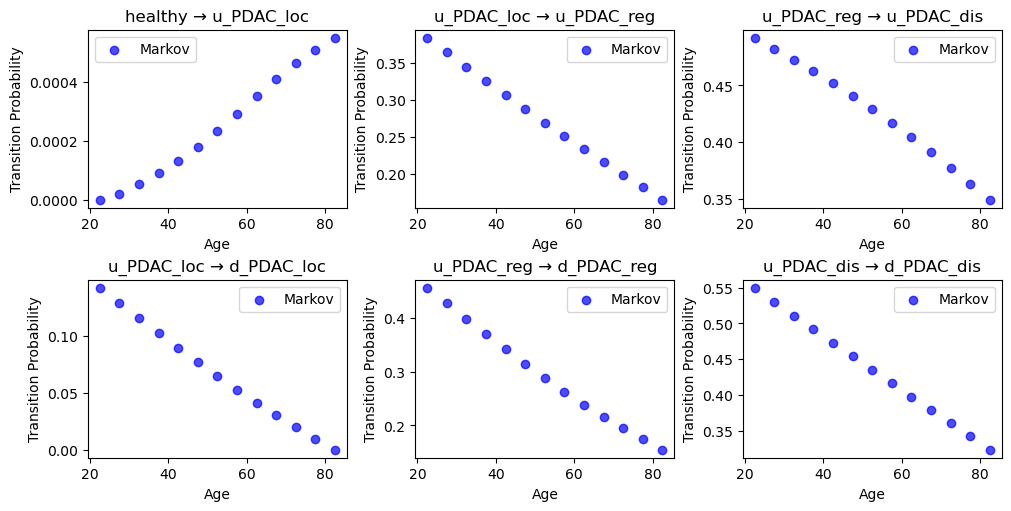

In [31]:
p.plot_params(result, show_plot=True)
markov_tmat = result
treeage_tmat = smooth_tmat(markov_tmat, save=False, timestamp="20241218_1605")
p.plot_params(markov_tmat, treeage_tmat, save_imgs=False, show_plot=True)